## Rede de ruas do OpenStreetMap com OSMnx e Python #4
### Caminho mais curto com NetworkX

#### Para o blog [paulovitorweb.wordpress.com](https://paulovitorweb.wordpress.com/)

Dando continuidade à nossa série de postagens sobre a biblioteca OSMnx, dessa vez vamos usar algumas funções que nos permitem calcular o caminho mais curto entre dois nós da nossa rede. Para isso, vamos precisar, além das bibliotecas que já vínhamos usando, da NetworkX.

Vamos começar importanto as bibliotecas e baixando uma rede, neste caso o bairro Mangabeira da cidade de João Pessoa.

In [1]:
import osmnx as ox
import networkx as nx
ox.config(use_cache=True, log_console=True)
ox.__version__

'0.12'

In [2]:
place = "Mangabeira, João Pessoa, Brazil"
graph = ox.graph_from_place(place, network_type='drive')

Plotamos a rede:

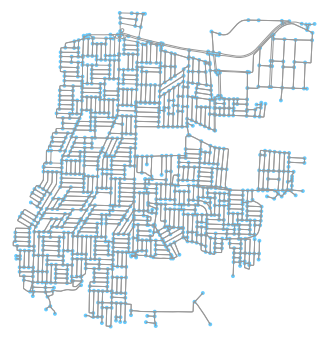

In [3]:
fig, ax = ox.plot_graph(graph)

Note abaixo que ela está em coordenadas geográficas.

In [4]:
print(ox.graph_to_gdfs(graph, nodes=False, edges=True).crs)

+proj=longlat +ellps=WGS84 +datum=WGS84 +no_defs


Precisamos utilizar um sistema métrico. Vamos reprojetar para coordenadas UTM usando a função `project_graph`, que identifica a zona apropriada.

In [5]:
graph_proj = ox.project_graph(graph)

Vamos plotar a rede reprojetada:

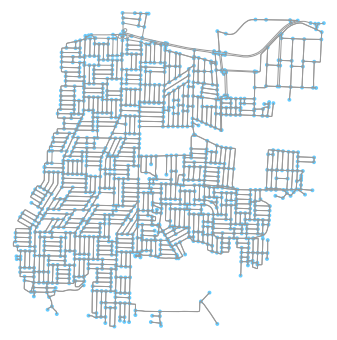

In [6]:
fig, ax = ox.plot_graph(graph_proj)

Vamos agora obter o GeoDataFrame, um objeto do geopandas, dos nós e dos segmentos (arestas) separadamente.

In [7]:
nod_proj, edg_proj = ox.graph_to_gdfs(graph_proj, nodes=True, edges=True)

Vamos dar uma olhada no atributo que traz informações sobre o sistema de coordenadas

In [8]:
edg_proj.crs

'+proj=utm +zone=25 +ellps=WGS84 +datum=WGS84 +units=m +no_defs'

Como esperado, agora está em UTM, e a zona é a 25. Está correto! Com nossa rede já projetada e convertida para dataframe, podemos prosseguir para a obtenção do caminho mais curto entre dois nós.

Neste exercício, como ponto de origem, vamos usar o centróide da nossa rede. Podemos fazer isso calculando o centróide da sua caixa delimitadora, unindo todos nossos registros em um MultiLineString (`edg_proj.unary_union`) e calculando latitude e longitude máximas e mínimas (`bounds`), e por fim passando estes valores como argumentos para a função `box` da biblioteca shapely que gera a geometria espacial.

In [9]:
from shapely.geometry import box
bbox = box(*edg_proj.unary_union.bounds)

In [10]:
print(bbox)

POLYGON ((299188.4052542785 -795312.603456618, 299188.4052542785 -791789.7633969767, 295791.3103270762 -791789.7633969767, 295791.3103270762 -795312.603456618, 299188.4052542785 -795312.603456618))


Definimos que o ponto de origem é o centróide dessa geometria.

In [11]:
orig_point = bbox.centroid

Como ponto de destino, um exercício interessante é obter o nó mais oriental da rede. Podemos obtê-lo calculando o maior valor de x. Primeiro, garantimos que o campo 'x' contenha valores do tipo `float`. Depois, calculamos o valor máximo.

In [12]:
nod_proj['x'] = nod_proj.x.astype(float)
maxx = nod_proj['x'].max()

Para localizar o registro que possui esse valor, usamos a função `loc` do pandas.

In [13]:
maxx_nod = nod_proj.loc[nod_proj['x']==maxx, :]
maxx_nod

,y,x,osmid,highway,lon,lat,geometry
2068809393,-791904.863676,299188.405254,2068809393,NaN,-34.818436,-7.160644,POINT (299188.405 -791904.864)


Aí está! Temos o nó mais oriental da rede. O índice do nó será utilizado na funçao de caminho mais próximo, então vamos guardá-lo:

In [14]:
targ_node = maxx_nod.index[0]

A função `get_nearest_node` obtém o nó da rede mais próximo de um par de coordenadas. Usa-se neste caso o método euclidiano. Como já temos o nó de destino, vamos obter agora o nó de origem, tomando como base, lembremos, o centróide da caixa delimitadora da nossa rede, na variável `orig_point`.

In [15]:
orig_node = ox.get_nearest_node(graph_proj, (orig_point.y, orig_point.x), method='euclidean')

Agora já podemos calcular o caminho mais curto entre os dois pontos por meio da função `shortest_path` da biblioteca networkX. O parâmetro `weight` representa a função de impedância, e, como queremos o caminho mais curto, passamos o atributo `length`. Se não definirmos isso, todos os segmentos terão peso 1.

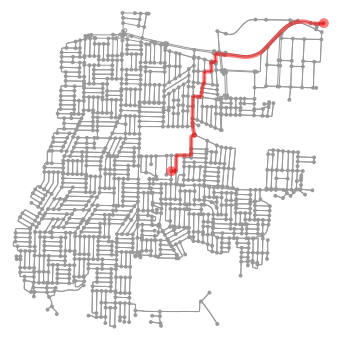

In [16]:
route = nx.shortest_path(graph_proj, orig_node, targ_node, weight='length')
fig, ax = ox.plot_graph_route(graph_proj, route)

Foi um bom exercício. Uma ressalva importante é que esse método pode desconsiderar conversões proibidas, principalmente em cruzamentos entre avenidas com canteiro central.

Outra forma de definir os nós é a partir dos índices. Isso é interessante quando sabemos o índice dos nós para os quais queremos calcular a rota.

In [17]:
first_node = list(graph_proj.nodes())[9]
last_node = list(graph_proj.nodes())[108]

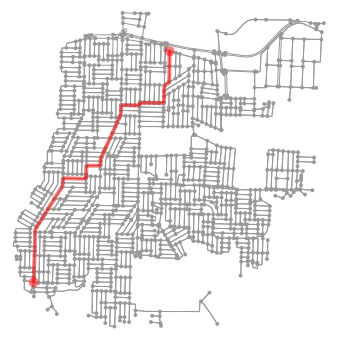

In [18]:
route = nx.shortest_path(graph_proj, first_node, last_node, weight='length')
fig, ax = ox.plot_graph_route(graph_proj, route)

Lembre-se que nossa rede considera o sentido da via (`network_type='drive'`), por isso, perceba como o caminho mais curto leva isso em consideração.

Podemos obter a distância em metros por meio da função `shortest_path_length` do networkX.

In [19]:
route_distance = nx.shortest_path_length(graph_proj, first_node, last_node, weight='length')
route_distance

3659.3939999999993

Nosso caminho mais curto neste caso possui então cerca de 3,7 km.

Podemos obter uma lista de coordenadas das linhas que compõem a rota com a função `node_list_to_coordinate_lines`. Usamos o parâmetro `use_geom=True` para que as linhas sejam desenhadas seguindo nossa rede, e não apenas linhas retas de nó pra nó.

In [20]:
lines = ox.node_list_to_coordinate_lines(graph_proj, route, use_geom=True)
lines[:5]

[[(296013.8471153404, -794817.5507550935),
  (296015.072006623, -794754.2685350525)],
 [(296015.072006623, -794754.2685350525),
  (296017.0857035151, -794703.0501701394)],
 [(296017.0857035151, -794703.0501701394),
  (296017.05362116557, -794695.0977806863)],
 [(296017.05362116557, -794695.0977806863),
  (296017.3280605236, -794653.5975768529)],
 [(296017.3280605236, -794653.5975768529),
  (296023.143748592, -794515.2290560019)]]

Outra coisa muito interessante que podemos fazer é filtrar os segmentos que compõem a rota dentro do GeoDataFrame. Fazemos isso convertendo nossa rota em uma lista de tuplas contendo os nós, e em seguida usamos pra filtrar o gdf pelo índice.

In [21]:
route_nodes = list(zip(route[:-1], route[1:]))
index = [edg_proj[(edg_proj['u']==u) & (edg_proj['v']==v)].index[0] for u, v in route_nodes]
edg_route = edg_proj.loc[index]
edg_route.head()

,u,v,key,osmid,highway,lanes,ref,name,oneway,length,geometry,maxspeed,junction,service,bridge
19,603688211,638990298,0,47430567,secondary,NaN,NaN,Rua Comerciante Alfredo Ferreira da Rocha,False,63.632,"LINESTRING (296013.847 -794817.551, 296015.072...",NaN,NaN,NaN,NaN
1098,638990298,638990091,0,47430567,secondary,NaN,NaN,Rua Comerciante Alfredo Ferreira da Rocha,False,51.531,"LINESTRING (296015.072 -794754.269, 296017.086...",NaN,NaN,NaN,NaN
1058,638990091,638990373,0,47430567,secondary,NaN,NaN,Rua Comerciante Alfredo Ferreira da Rocha,False,7.995,"LINESTRING (296017.086 -794703.050, 296017.054...",NaN,NaN,NaN,NaN
1174,638990373,638990106,0,47430567,secondary,NaN,NaN,Rua Comerciante Alfredo Ferreira da Rocha,False,41.723,"LINESTRING (296017.054 -794695.098, 296017.328...",NaN,NaN,NaN,NaN
1070,638990106,638990388,0,47430567,secondary,NaN,NaN,Rua Comerciante Alfredo Ferreira da Rocha,False,139.228,"LINESTRING (296017.328 -794653.598, 296023.144...",NaN,NaN,NaN,NaN


Assim, temos acesso a todos os campos das arestas, como nome do logradouro e extensão. Por exemplo, podemos obter o mesmo resultado da função `shortest_path_length` apenas somando o campo `length`.

In [22]:
edg_route['length'].sum()

3659.3940000000002

É isso.

Sugestão de material para quem quer se aprofundar: https://github.com/gboeing/osmnx-examples e https://automating-gis-processes.github.io/site/notebooks/L6/network-analysis.html